In [ ]:

import os
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss

# Define the paths to the datasets
normal_dir = '/content/drive/MyDrive/AYYO DEVARE/Result/NORMAL ENC 3.5'
benign_dir = '/content/drive/MyDrive/AYYO DEVARE/Result/BENIGN ENC 3.5'
malignant_dir = '/content/drive/MyDrive/AYYO DEVARE/Result/MALIGNANT ENC 3.5'

# Classes and directories
classes = ['normal', 'benign', 'malignant']
input_dirs = [normal_dir, benign_dir, malignant_dir]

# Function to load images from a directory and return as numpy arrays
def load_images_from_directory():
    images = []
    labels = []
    for label, class_dir in enumerate(input_dirs):
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load images and labels from directories
all_images, all_labels = load_images_from_directory()

# Normalize the images
all_images = all_images / 255.0

# Convert labels to categorical
all_labels = to_categorical(all_labels, num_classes=len(classes))

# Split the dataset: 70% train, 20% test, 10% validation
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=2/3, random_state=42, stratify=temp_labels)


57/57 [==============================] - 46s 802ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


SVM + XGBoost Ensemble Combined Test accuracy: 0.8978
SVM + XGBoost Ensemble Combined Test loss: 0.2649
SVM + XGBoost Ensemble Classification Report:
              precision    recall  f1-score   support

      Normal       0.85      0.87      0.86       900
      Benign       0.86      0.84      0.85       900
   Malignant       0.99      0.98      0.98       900

    accuracy                           0.90      2700
   macro avg       0.90      0.90      0.90      2700
weighted avg       0.90      0.90      0.90      2700



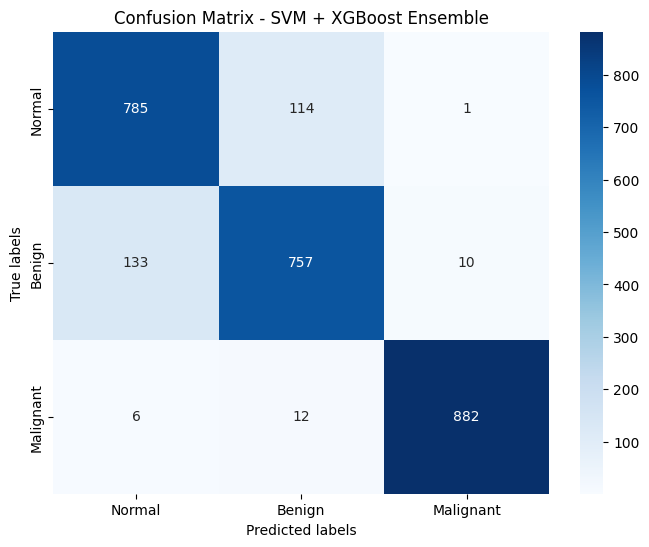

In [ ]:

# Load DenseNet201 without top classification layers
densenet201_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add GlobalAveragePooling layer
densenet201_output = GlobalAveragePooling2D()(densenet201_model.output)

# Create model for feature extraction
densenet201_extractor = Model(inputs=densenet201_model.input, outputs=densenet201_output)

# Assuming train_images, train_labels, val_images, val_labels, test_images, test_labels are defined elsewhere

# Extract features from DenseNet201
train_features_densenet201 = densenet201_extractor.predict(train_images)
val_features_densenet201 = densenet201_extractor.predict(val_images)
test_features_densenet201 = densenet201_extractor.predict(test_images)

# Combine features
train_features = train_features_densenet201
val_features = val_features_densenet201
test_features = test_features_densenet201

# Combine validation and test features for classification
combined_features = np.concatenate((val_features, test_features), axis=0)
combined_labels = np.concatenate((np.argmax(val_labels, axis=1), np.argmax(test_labels, axis=1)), axis=0)

# Train individual classifiers
svm = SVC(probability=True)
xgb = XGBClassifier()

classifiers = {

    'SVM': svm,
    'XGBoost': xgb,
}

# Fit individual classifiers on the training features
for name, clf in classifiers.items():
    clf.fit(train_features, np.argmax(train_labels, axis=1))

# Create separate ensembles
svm_xgb_ensemble = VotingClassifier(estimators=[
    ('svm', svm),
    ('xgb', xgb)
], voting='soft')

# Fit SVM + XGBoost ensemble
svm_xgb_ensemble.fit(train_features, np.argmax(train_labels, axis=1))




# Evaluate SVM + XGBoost ensemble
for name, clf in {'SVM + XGBoost Ensemble': svm_xgb_ensemble}.items():
    preds = clf.predict(combined_features)
    prob_preds = clf.predict_proba(combined_features)
    accuracy = accuracy_score(combined_labels, preds)
    loss = log_loss(combined_labels, prob_preds)
    print(f'{name} Combined Test accuracy: {accuracy:.4f}')
    print(f'{name} Combined Test loss: {loss:.4f}')

    conf_matrix = confusion_matrix(combined_labels, preds)
    print(f'{name} Classification Report:')
    print(classification_report(combined_labels, preds, target_names=['Normal', 'Benign', 'Malignant']))
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Benign', 'Malignant'], yticklabels=['Normal', 'Benign', 'Malignant'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

In [ ]:
import joblib

# Define the directory to save the model
model_save_directory = '/content/drive/MyDrive/AYYO DEVARE/NEW'  # Update this to your desired path

# Save the individual classifiers
joblib.dump(svm, os.path.join(model_save_directory, 'svm_model.pkl'))
joblib.dump(xgb, os.path.join(model_save_directory, 'xgboost_model.pkl'))

# Save the ensemble model
joblib.dump(svm_xgb_ensemble, os.path.join(model_save_directory, 'svm_xgb_ensemble.pkl'))

# Save the DenseNet feature extractor if needed
densenet_model_path = os.path.join(model_save_directory, 'densenet201_extractor.h5')
densenet201_extractor.save(densenet_model_path)

print("Models saved successfully!")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Models saved successfully!
